# Stock prediction
Quantitative analysis of *certain variables* and their correlation with stock price behaviour. This used to be hard, but now with powerful tools and libraries like tensorflow it is much simpler.

In the 1980's two British statisticians, Box and Jenkins, created a mainframe program to attempt to predict stock prices from just two data points, price and volume. It was known as Autoregressive Integrated Moving Average (ARIMA).

The Box-Jenkins approach claims that non-stationary data can be made stationary by differencing the series, Y<sub>t</sub> :

Y<sub>t</sub> = &Phi;<sub>1</sub>Y<sub>t-1</sub>+&Phi;<sub>2</sub>Y<sub>t-2</sub>...&Phi;<sub>&rho;</sub>Y<sub>t-&rho;</sub>+&epsilon;<sub>t</sub>+&theta;<sub>1</sub>&epsilon;<sub>t-1</sub>+&theta;<sub>2</sub>&epsilon;<sub>t-2</sub>+...&theta;<sub>q</sub>&epsilon;<sub>t-q</sub>

The ARIMA model combines three basic methods:

1. *AutoRegression (AR)* – Auto-regression, the values of a given time series data are regressed on their own lagged values, which is indicated by the “p” value in the model.
2. *Differencing (I-for Integrated)* – Conversion of a non-stationary time series to a stationary one to remove time trends. This is indicated by the “d” value in the model. If d = 1, it looks at the difference between two time series entries, if d = 2 it looks at the differences of the differences obtained at d =1, and so forth.
3. *Moving Average (MA)* – The moving average nature of the model is represented by the “q” value which is the number of lagged values of the error term.


## A modern approach using artificial intelligence (AI)
The code below uses Keras, an API used to simplify prototyping on top of AI frameworks like Google's Tensorflow. Google Tensorflow has its own flavour of Keras, which I use below with Python 3.6 to build a deep learning model.

The very simple approach below uses only a single data point, the *closing price* with a deep neural network of only 2 layers using time sequence analysis recurrent networks variant LSTMs.

### Data set
Our data is from the daily closing prices from S&P 500 from Jan 2000 to Aug 2016. The series is index in time order.

### Goal
Our goal is to predict the closing price for any given date.

In [1]:
import tensorflow as tf
import time #helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
#is tensorflow installed correctly?
hello = tf.constant('Hello, TensorFlow! Did you install?')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow! Did you install?'


In [3]:
#use Keras from tensorflow, a slightly modifiedx version
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Activation
from numpy import newaxis

## 1. Load Data
Load in the data and then normalise.
Splits the data into:
* train
* validate
* test

### Normalise the data
Normalising data improves convergence. To [normalize the data](https://en.wikipedia.org/wiki/Normalization_(statistics)) we use the following equation to adjust the values measured on different scales to a *notionally* common scale:

*n<sub>i</sub> = (P<sub>i</sub> / P<sub>O</sub>) -* 1

The final step in training the Keras LSTM model is to call the [fit_generator](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. 

When training neural networks, the data is generally fed in small batches, called mini-batches or just “batches”.

Keras has some handy functions to extract training data automatically from a predefined Python iterator object, one is called *fit_generator*. Its first argument is the *iterator* function we need to define to extract batches of data during the training process.

This function in Keras will handle all of the data extraction, input into the model, executing gradient steps, logging metrics such as accuracy and executing callbacks (these will be discussed later).

The funtion should be similiar to the following format:

```
while True:
    #do some things to create a batch of data (x, y)
    yield x, y
```

Ours is:
> normalised_window = [((float(p) / float(window[0])) - 1) for p in window]


In [4]:
#normalise the data

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

### Reshape the data
While performing machine learning the data needs to be split into 3 parts:

1. *Training set* - to train the model and prepare the weights in the model.
2. *Test* - to estimate how well the model has been trained and estimate model properties (mean error for numeric predictors, classification errors for classifiers, recall and precision for IR-models etc.)
3. *Validation/Application* - a seperated clean set (removing bias from training and testing) 

In [5]:
# load the data, split and normalize
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

X_train, y_train, X_test, y_test = load_data('sp500.csv', 50, True)

## 2. Build the model
### model
Models in Keras come in 2 forms - Sequential and Functional. 
Sequential allows layers to be stacked in order of input to output. 
The functional API allows for more complex architectures.

In [6]:
#The first line declares the model type as Sequential().
model = Sequential()

In [8]:
# Model parameters
hidden_size = 50
dropout_rate = 0.2

### LSTM
Long short term memory (LSTM), they solve the vanishing gradient issue, allowing a network to keep the impact of weights to learn long-term dependencies. A LSTM network is a recurrent neural network. A recurrent neural network is a neural network that models time or sequence dependent behaviour – such as language, stock prices, electricity demand and so on. This is performed by feeding back the output of a neural network layer at time t to the input of the same network layer at time t + 1. So there is some influence from what went before.

We match this to the size of the embedding layer.

In [9]:
# hidden layer 1
hidden_size = 50 # Positive integer, dimensionality of the output space.
model.add(LSTM(hidden_size, return_sequences=True))

model.add(Dropout(dropout_rate))

In [10]:
# hidden layer 2
hidden_size = 100 # Positive integer, dimensionality of the output space.
model.add(LSTM(hidden_size, return_sequences=False))

model.add(Dropout(dropout_rate))

In [11]:
# output an array of dimension 1
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
model.add(Dense(1))

In [12]:
# The name of the activation finction to use
model.add(Activation('linear'))

Run the compile command on the constructed model.

* *mse* - mean squared error, an estimator that measures the average squared difference between the estimated values and what is estimated.
* *rmsprop* - Adaptive gradient descent algorithms like Adagrad and RMSprop provide and an alternative to Stochastic gradient descent (SGD), which is useful with sparse data. RMSprop adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. 
> keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
* ‘categorical_accuracy’, which can let us see how the accuracy is improving during training.


In [13]:
start = time.time()
model.compile(loss='mse', optimizer='rmsprop', metrics=['categorical_accuracy'])
print ('compilation time : ', time.time() - start)

compilation time :  0.011169910430908203


## Checkpoint
Create a checkpoint using a Keras *callback*, these functions can *optionally be called at the end of a training epoch.

This callback saves the model after each epoch, useful for running long-term training.

*Note* that the model checkpoint function can include the epoch in its naming of the model, which is good for keeping track of things.

In [14]:
data_path = "/Users/Dom/projects/stocks"
checkpointer = keras.callbacks.ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)

## 3. Train the model
Use the data loaded to train the model.

In [15]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=2,
    validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/2
3523/3523 [==============================] - 4s 1ms/step - loss: 0.0029 - categorical_accuracy: 1.0000 - val_loss: 0.0015 - val_categorical_accuracy: 1.0000
Epoch 2/2
3523/3523 [==============================] - 2s 560us/step - loss: 6.9042e-04 - categorical_accuracy: 1.0000 - val_loss: 7.3100e-04 - val_categorical_accuracy: 1.0000


In [16]:
model.evaluate(X_test, y_test)

412/412 [==============================] - 0s 738us/step


[0.0003815509203156836, 1.0]

## Step 4 - Predict
Predict sequence of 50 steps before shifting prediction run forward by 50 steps

In [17]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(math.floor(len(data)/prediction_len))):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

predictions = predict_sequences_multiple(model, X_test, 50, 50)

## Step 5 - Plot the predictions!


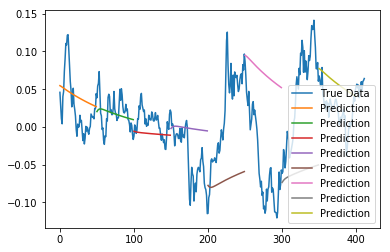

In [18]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')

    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

plot_results_multiple(predictions, y_test, 50)

## Resources
*  [Understanding LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
*  [Analysis](http://deeplearning.net/tutorial/lstm.html)
*  [Eclipse Deeplearning4j](https://deeplearning4j.org/)
*  [Recurrent rnn](https://www.tensorflow.org/tutorials/sequences/recurrent)
*  [Time series prediction on Keras on Tensorflow](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
*  [Evaluate performance](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/)
